In [1]:
!pip install -q -U git+https://github.com/lvwerra/trl.git
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q langchain
!pip install -q einops
!pip install -q -U wandb

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 18.9 MB/s eta 0:00:00
  Installing build dep

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset

import torch

import transformers
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
from transformers import TrainingArguments

from peft import LoraConfig

from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
from langchain.prompts import PromptTemplate

from IPython.display import Markdown, display

In [3]:
import wandb
from google.colab import userdata
api_key = userdata.get('wandb')
wandb.login(key=api_key)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
os.environ["WANDB_PROJECT"] = "Fine-Tuning Falcon 7B With QLORA"

In [7]:
data = load_dataset("csv", data_files="/content/Datasets/train.csv")
data

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'prompt', 'A', 'B', 'C', 'D', 'E', 'answer'],
        num_rows: 200
    })
})

In [8]:
template = """Answer the following multiple choice question by giving the most appropriate response. Answer should be one among [A, B, C, D, E]

Question: {prompt}\n
A) {a}\n
B) {b}\n
C) {c}\n
D) {d}\n
E) {e}\n

Answer: {answer}"""

prompt = PromptTemplate(template=template, input_variables=['prompt', 'a', 'b', 'c', 'd', 'e', 'answer'])

In [9]:
sample = data['train'][0]
display(Markdown(prompt.format(prompt=sample['prompt'],
                               a=sample['A'],
                               b=sample['B'],
                               c=sample['C'],
                               d=sample['D'],
                               e=sample['E'],
                               answer=sample['answer'])))

Answer the following multiple choice question by giving the most appropriate response. Answer should be one among [A, B, C, D, E]

Question: Which of the following statements accurately describes the impact of Modified Newtonian Dynamics (MOND) on the observed "missing baryonic mass" discrepancy in galaxy clusters?

A) MOND is a theory that reduces the observed missing baryonic mass in galaxy clusters by postulating the existence of a new form of matter called "fuzzy dark matter."

B) MOND is a theory that increases the discrepancy between the observed missing baryonic mass in galaxy clusters and the measured velocity dispersions from a factor of around 10 to a factor of about 20.

C) MOND is a theory that explains the missing baryonic mass in galaxy clusters that was previously considered dark matter by demonstrating that the mass is in the form of neutrinos and axions.

D) MOND is a theory that reduces the discrepancy between the observed missing baryonic mass in galaxy clusters and the measured velocity dispersions from a factor of around 10 to a factor of about 2.

E) MOND is a theory that eliminates the observed missing baryonic mass in galaxy clusters by imposing a new mathematical formulation of gravity that does not require the existence of dark matter.


Answer: D

In [10]:
def format_text(example):
    text = prompt.format(prompt=example['prompt'],
                         a=example['A'],
                         b=example['B'],
                         c=example['C'],
                         d=example['D'],
                         e=example['E'],
                         answer=example['answer'])
    return {"text": text}

In [11]:
data = data.map(format_text)
data

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'prompt', 'A', 'B', 'C', 'D', 'E', 'answer', 'text'],
        num_rows: 200
    })
})

In [12]:
def plot_sequence_lengths(data, split='train', max_length=2048):
    sequence_lengths = []
    keep_indices = []

    # Loop over the dataset and get the lengths of text sequences
    for i, example in enumerate(data[split]):
        sequence_lengths.append(len(example['text']))
        if sequence_lengths[i] < max_length:
            keep_indices.append(i)

    # Plot the histogram
    plt.hist(sequence_lengths, bins=30)
    plt.xlabel('Sequence Length')
    plt.ylabel('Count')
    plt.title('Distribution of Text Sequence Lengths')
    plt.show()

    return keep_indices

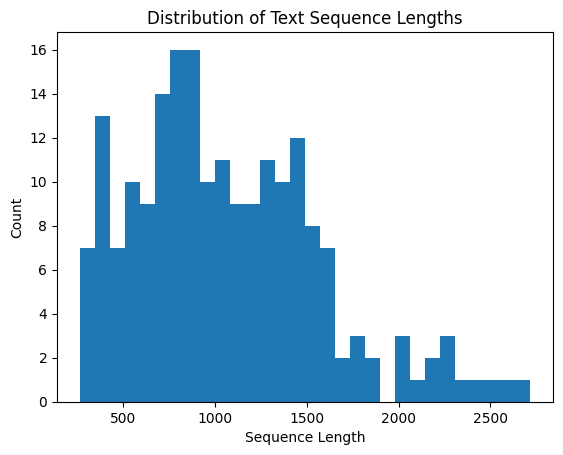

In [13]:
keep_indices_train = plot_sequence_lengths(data)

In [14]:
data['train'] = data['train'].select(keep_indices_train)

In [15]:
model_id = "tiiuae/falcon-7b"

In [16]:
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [17]:
qlora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["query_key_value", "dense", "dense_h_to_4h", "dense_4h_to_h"],
    task_type="CAUSAL_LM"
)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [18]:
base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    trust_remote_code=True,
    revision="2f5c3cd4eace6be6c0f12981f377fb35e5bf6ee5"
)

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

configuration_RW.py:   0%|          | 0.00/2.61k [00:00<?, ?B/s]

modelling_RW.py:   0%|          | 0.00/47.6k [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


pytorch_model.bin.index.json:   0%|          | 0.00/16.9k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/4.48G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [19]:
training_args = TrainingArguments(
    output_dir="./SFT-Falcon-7b",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    learning_rate=2e-4,
    logging_steps=20,
    logging_strategy="steps",
    max_steps=100,
    optim="paged_adamw_8bit",
    fp16=True,
    run_name="baseline-falcon-sft"
)

In [20]:
supervised_finetuning_trainer = SFTTrainer(
    base_model,
    train_dataset=data["train"],
    args=training_args,
    tokenizer=tokenizer,
    peft_config=qlora_config,
    dataset_text_field="text",
    max_seq_length=2048,
    data_collator=DataCollatorForCompletionOnlyLM(tokenizer=tokenizer,
                                                  response_template="Answer:")
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:287: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:315: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/189 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:500: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
max_steps is given, it will override any value given in num_train_epochs


In [21]:
supervised_finetuning_trainer.train()

wandb: Currently logged in as: sosamaali (midconstruct). Use `wandb login --relogin` to force relogin


Step,Training Loss
20,1.776700
40,1.629500
60,1.568200
80,1.491600
100,1.305800


config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

You are using a model of type falcon to instantiate a model of type RefinedWebModel. This is not supported for all configurations of models and can yield errors.


TrainOutput(global_step=100, training_loss=1.5543923950195313, metrics={'train_runtime': 116.2817, 'train_samples_per_second': 6.88, 'train_steps_per_second': 0.86, 'total_flos': 9891725708539392.0, 'train_loss': 1.5543923950195313, 'epoch': 4.166666666666667})

In [22]:
supervised_finetuning_trainer.save_model('.')

You are using a model of type falcon to instantiate a model of type RefinedWebModel. This is not supported for all configurations of models and can yield errors.
